In [71]:
from pyspark.context import SparkContext
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
import pandas as pd 
import pandas.tools.plotting as pdplt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [72]:
sc = SparkContext.getOrCreate()

## Preprocessing the data using OneHotEncoder

In [73]:
data_path = "./HR_comma_sep.csv"
dataset = spark.read.options(header="true", parserLib="univocity", inferSchema="true").csv(data_path)
cols = dataset.columns
print dataset.dtypes

[('satisfaction_level', 'double'), ('last_evaluation', 'double'), ('number_project', 'int'), ('average_montly_hours', 'int'), ('time_spend_company', 'int'), ('Work_accident', 'int'), ('left', 'int'), ('promotion_last_5years', 'int'), ('sales', 'string'), ('salary', 'string')]


In [74]:
categoricalColumns = ["sales", "salary"]
stages = []

for categoricalCol in categoricalColumns: 
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
    encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
    stages += [stringIndexer, encoder]

In [75]:
label_string_indexer = StringIndexer(inputCol = "left", outputCol = "label")
stages += [label_string_indexer]

In [76]:
numericColumns = ['number_project',
                  'average_montly_hours',
                  'time_spend_company',
                  'Work_accident', 
                  'promotion_last_5years']

assemblerInputs = map(lambda c: c + "classVec", categoricalColumns) + numericColumns
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

In [77]:
print dataset.columns

['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'left', 'promotion_last_5years', 'sales', 'salary']


In [78]:
pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(dataset)
dataset = pipelineModel.transform(dataset)
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
dataset.show()

+-----+--------------------+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+-----+------+
|label|            features|satisfaction_level|last_evaluation|number_project|average_montly_hours|time_spend_company|Work_accident|left|promotion_last_5years|sales|salary|
+-----+--------------------+------------------+---------------+--------------+--------------------+------------------+-------------+----+---------------------+-----+------+
|  1.0|(16,[0,9,11,12,13...|              0.38|           0.53|             2|                 157|                 3|            0|   1|                    0|sales|   low|
|  1.0|(16,[0,10,11,12,1...|               0.8|           0.86|             5|                 262|                 6|            0|   1|                    0|sales|medium|
|  1.0|(16,[0,10,11,12,1...|              0.11|           0.88|             7|                 272|                 4|            0|   

## Visualizing the data

In [20]:
visualizedf = dataset.toPandas()
visualizedf['Department'] = visualizedf['sales']
visualizedf.drop(['sales'], axis = 1, inplace = True)

In [21]:
evalMean = visualizedf['last_evaluation'].mean()
evalStd = np.std(visualizedf['last_evaluation'])
visualizedf['Performance(standard units)'] = (visualizedf['last_evaluation']- evalMean)/evalStd

In [22]:
def performance_label(row):
    performance = row['Performance(standard units)']
    if performance >=1:
        result = '>Average'
    else:
        result = '<=Average'
        
    return(result)

In [23]:
visualizedf['performance label'] = visualizedf.apply(performance_label, axis = 1)
left_dict = {1: 'left', 0: 'stayed'}
visualizedf['left(as_string)'] = (visualizedf['left'].map(left_dict))
salary_dict = {'low': 60000, 'medium': 100000, 'high': 150000}
visualizedf['salary_estimate'] = visualizedf['salary'].map(salary_dict)

In [24]:
columns = (visualizedf.columns)
num_columns = (visualizedf._get_numeric_data().columns)

hrData = visualizedf
hrData['Feature title'] = hrData['left(as_string)'] + ' : ' + hrData['performance label']

hrData_pivot = hrData.pivot_table(index= (['Feature title']), values =num_columns, aggfunc=np.mean)
hrData_pivot.transpose()

Feature title,left : <=Average,left : >Average,stayed : <=Average,stayed : >Average
Performance(standard units),-0.540078,1.352882,-0.326718,1.319193
Work_accident,0.050988,0.038425,0.175504,0.172983
average_montly_hours,187.898024,254.862632,198.254872,202.358003
label,1.000000,1.000000,0.000000,0.000000
last_evaluation,0.623660,0.947666,0.660180,0.941899
left,1.000000,1.000000,0.000000,0.000000
number_project,3.310672,5.179635,3.777137,3.825680
promotion_last_5years,0.007115,0.000961,0.026347,0.025858
salary_estimate,77015.810277,76340.057637,87348.938487,85818.100758
satisfaction_level,0.399787,0.538069,0.663585,0.680013


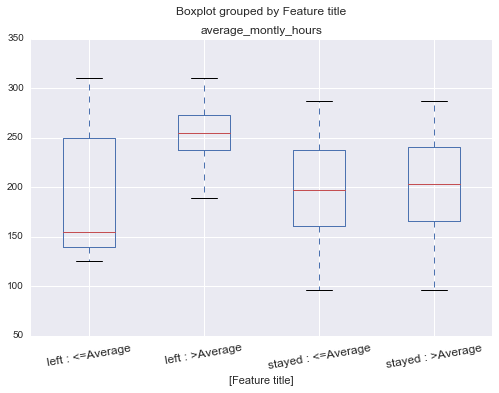

In [26]:
hrData[['Feature title', 'average_montly_hours']].boxplot(by = 'Feature title')
plt.xticks(rotation = 10)
plt.show()

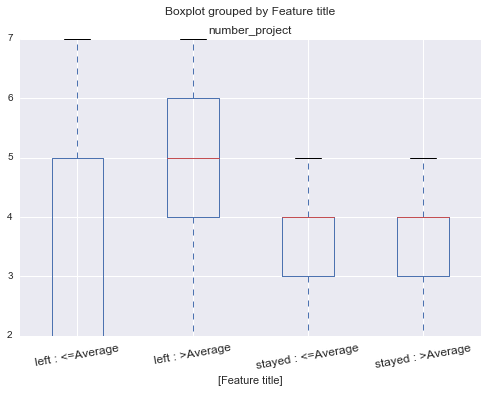

In [27]:
hrData[['Feature title', 'number_project']].boxplot(by = 'Feature title')
plt.xticks(rotation = 10)
plt.show()

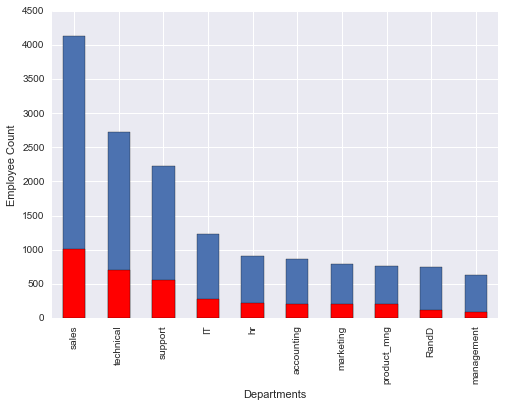

In [29]:
left_data = hrData[hrData.left == 1]
hrData.Department.value_counts().plot(kind='bar')
left_data.Department.value_counts().plot(kind='bar', color = 'red')
plt.title =('Share of Employees that Left by Department')
plt.xlabel('Departments')
plt.ylabel('Employee Count')
plt.show()

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


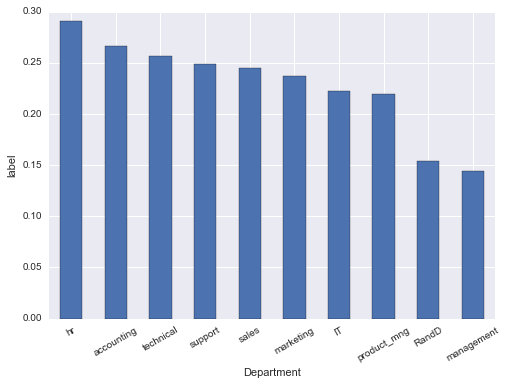

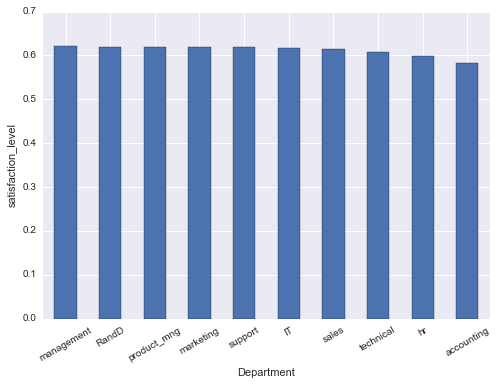

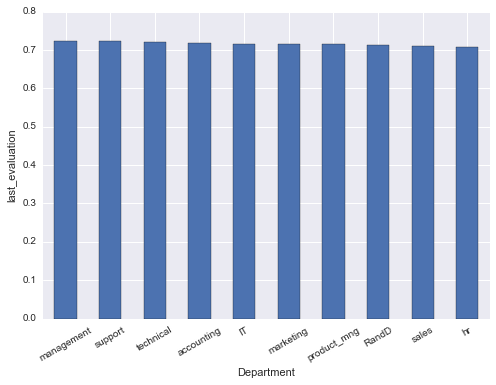

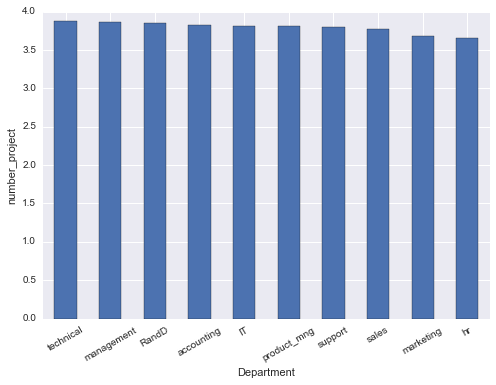

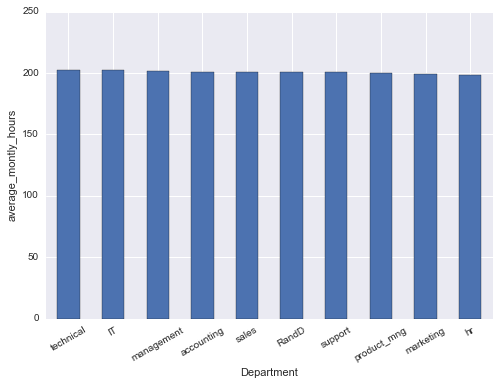

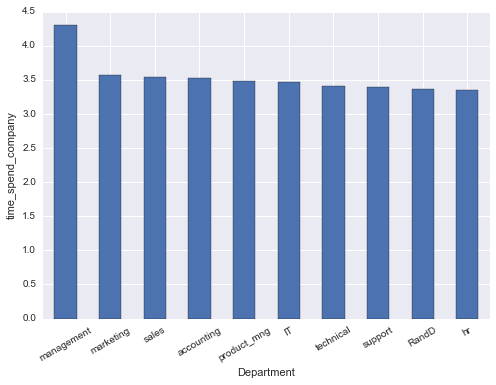

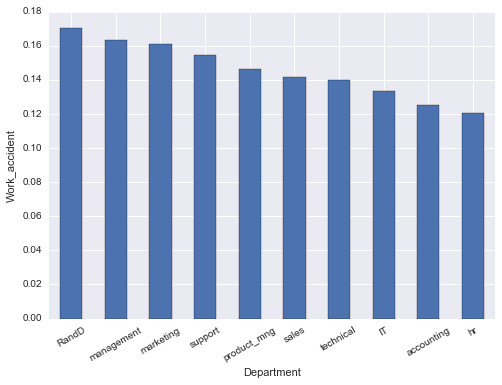

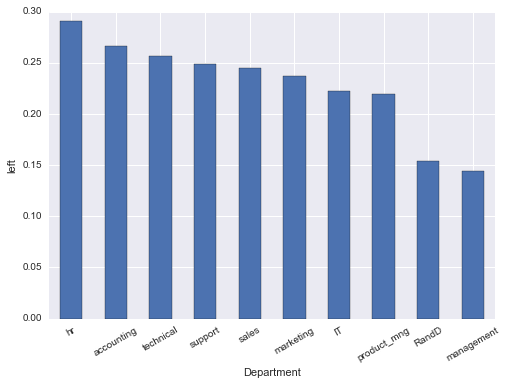

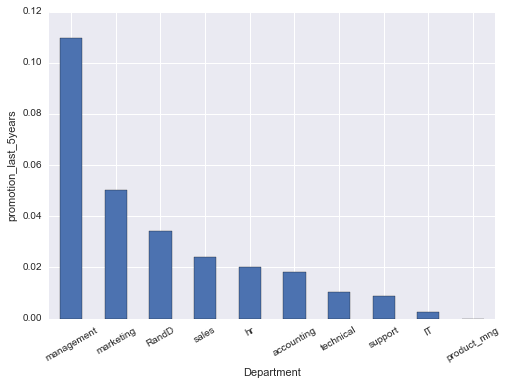

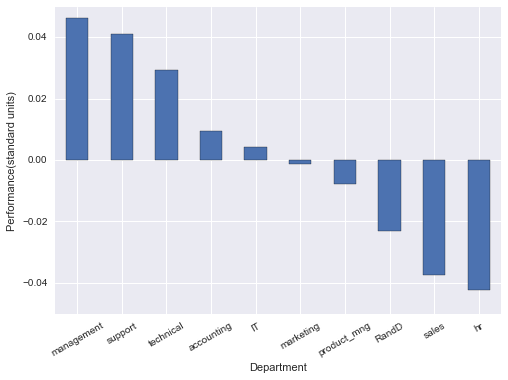

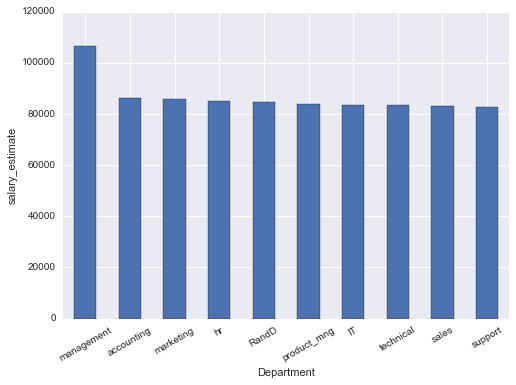

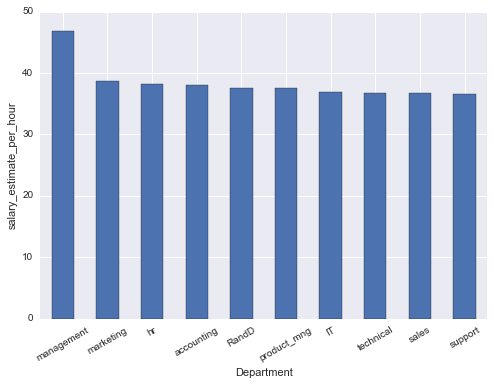

In [30]:
hrData['salary_estimate_per_hour'] = hrData.salary_estimate/(hrData.average_montly_hours *12)

hr_data_by_dept = hrData.groupby(['Department']).mean()

for col in hr_data_by_dept.columns:
    hr_data_sorted = hr_data_by_dept.sort(col, ascending = False)
    hr_data_sorted[col].plot(kind = 'bar')
    plt.ylabel(col)
    plt.xticks( rotation = 30)
    plt.show()

## Plotting cumulative distributed function for the features

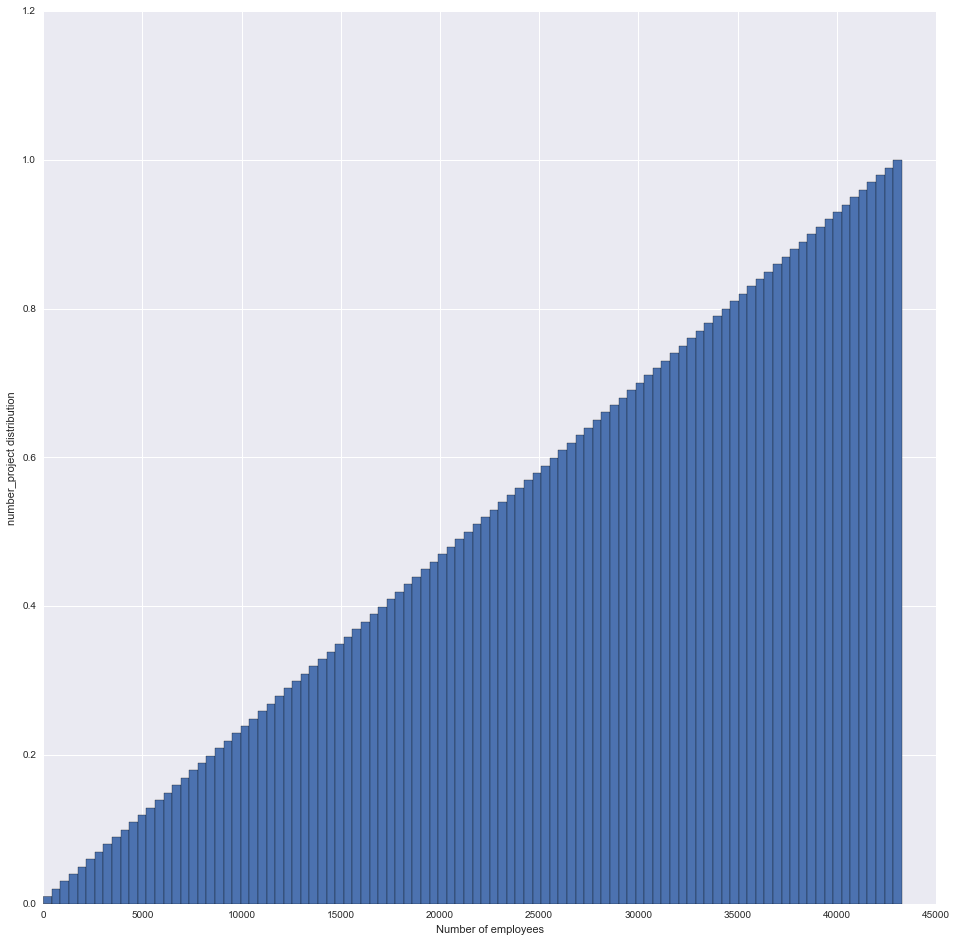

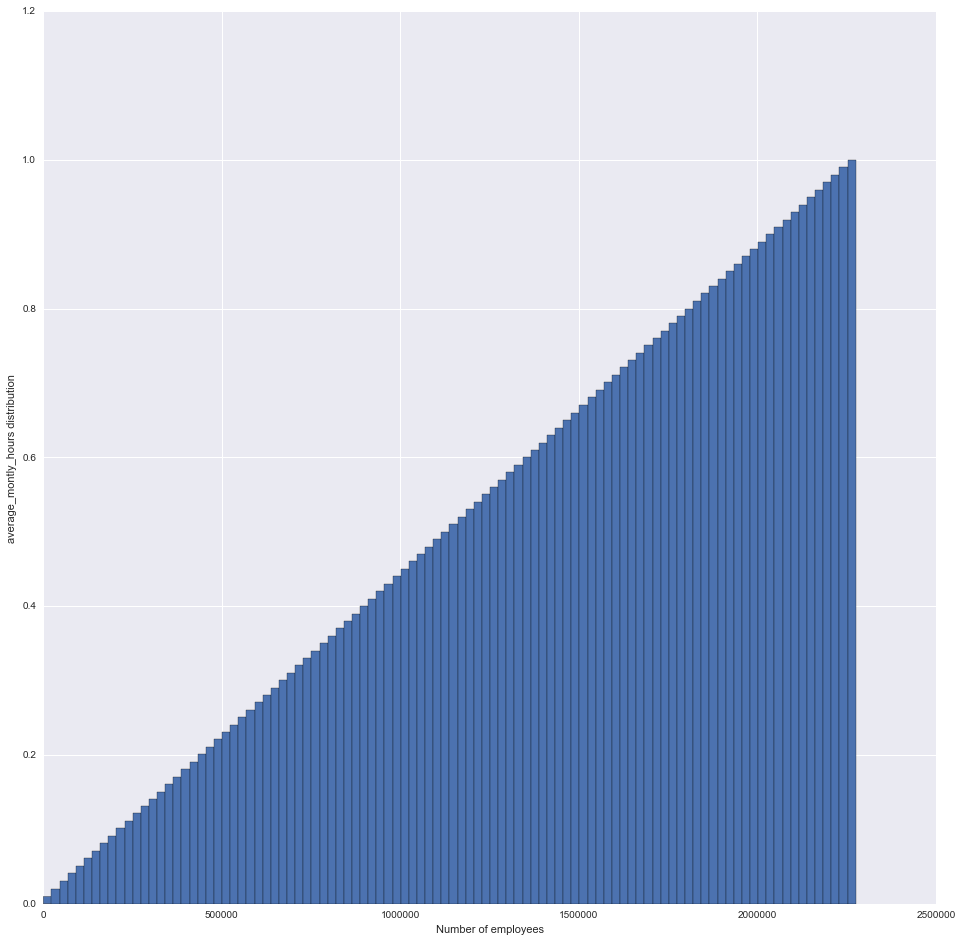

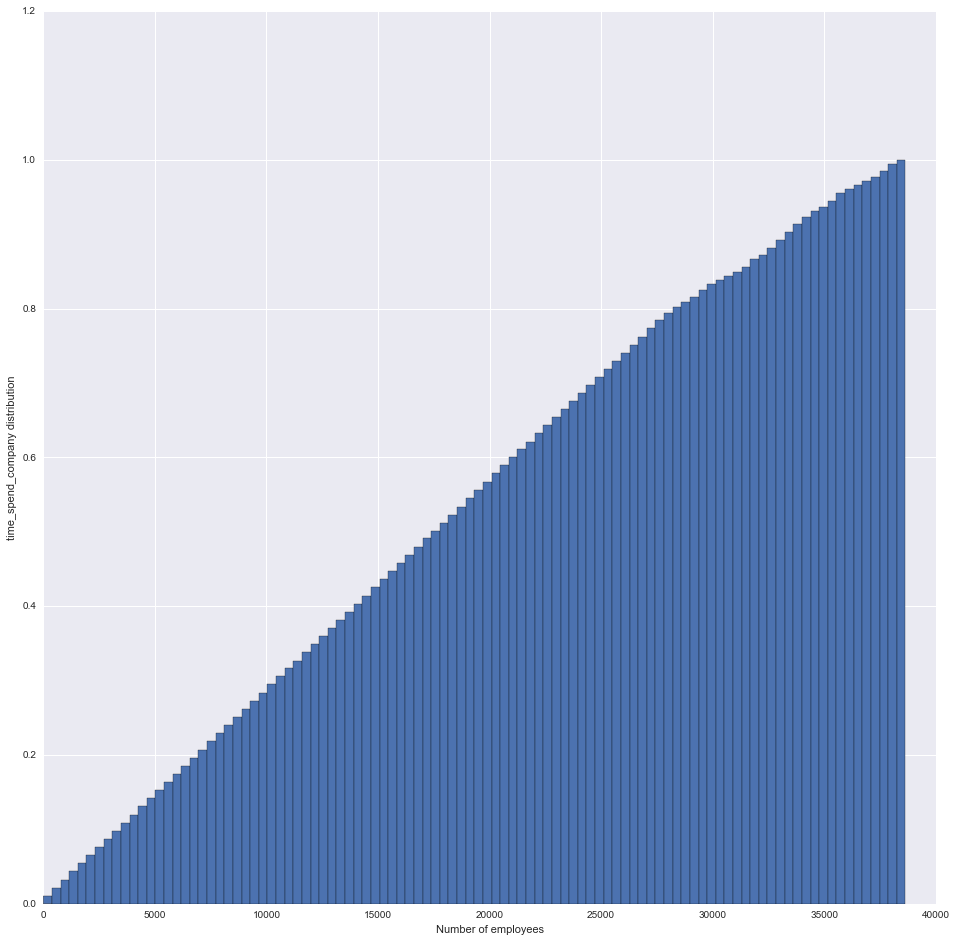

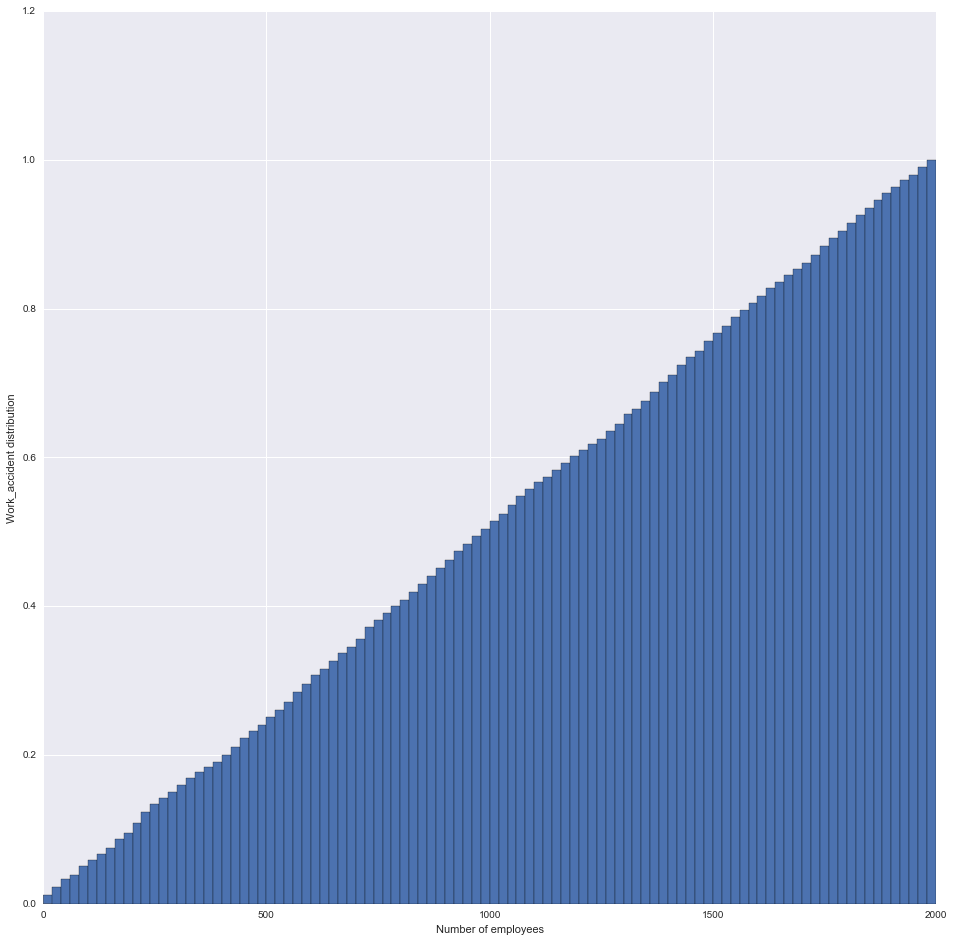

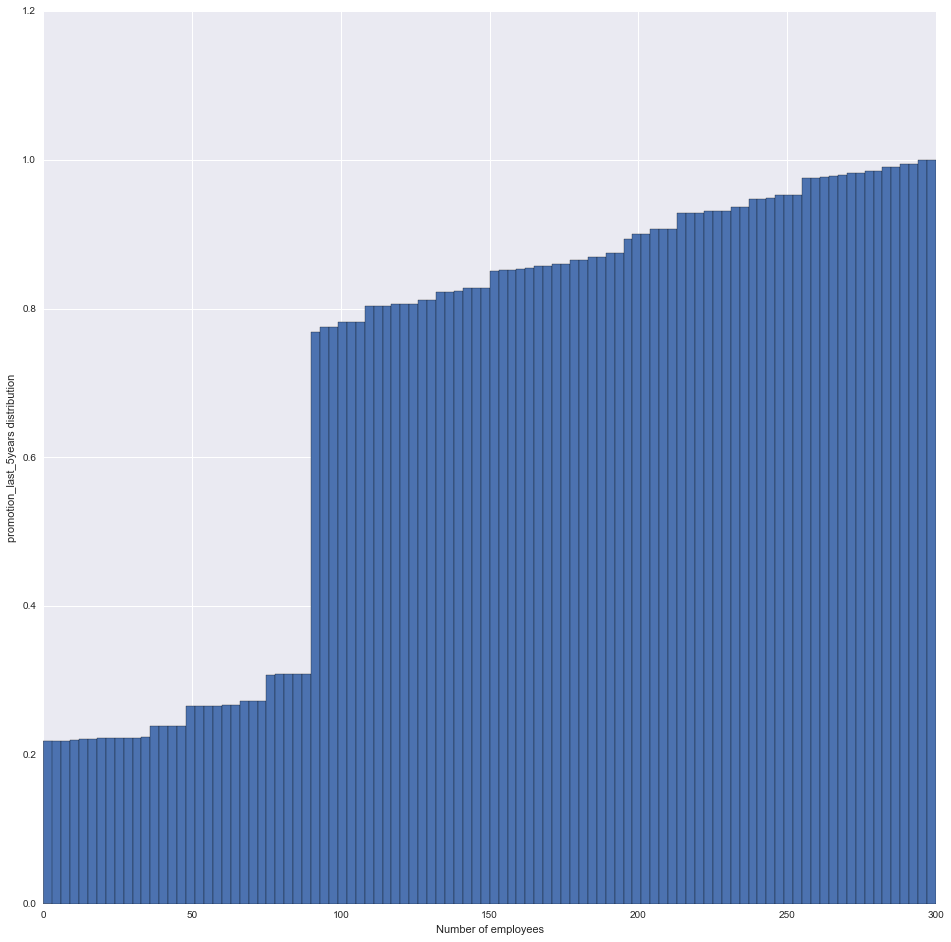

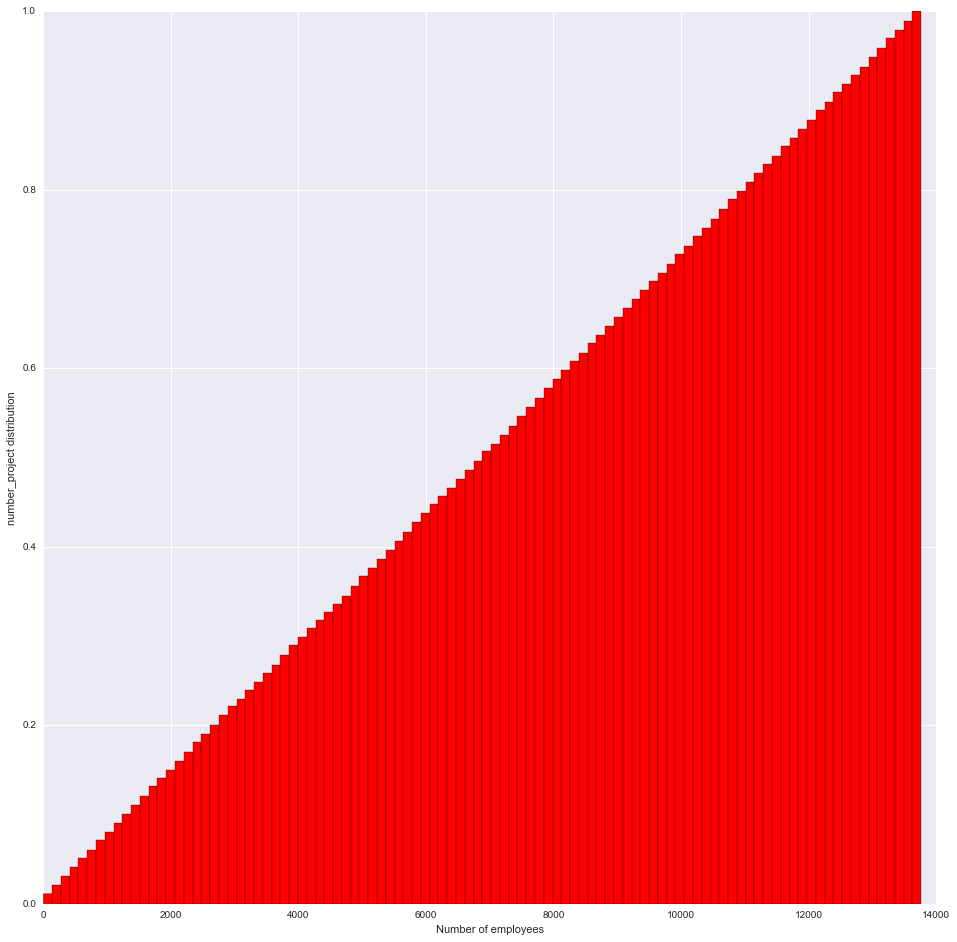

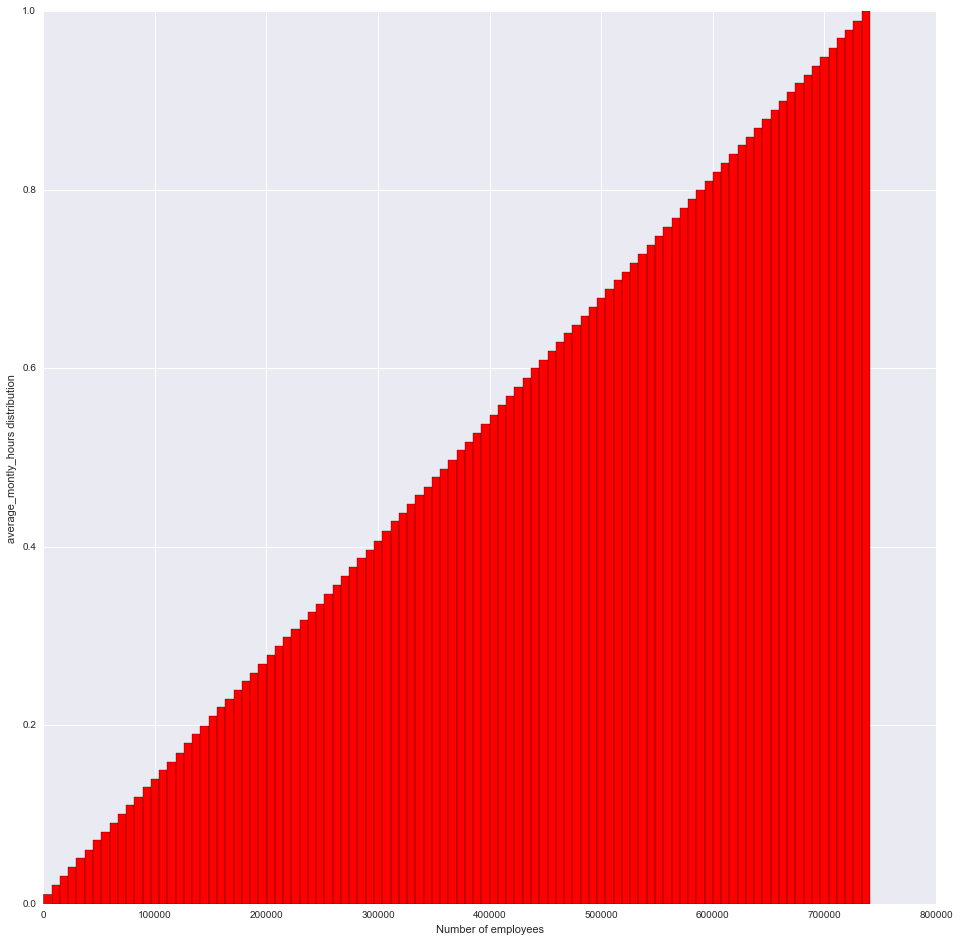

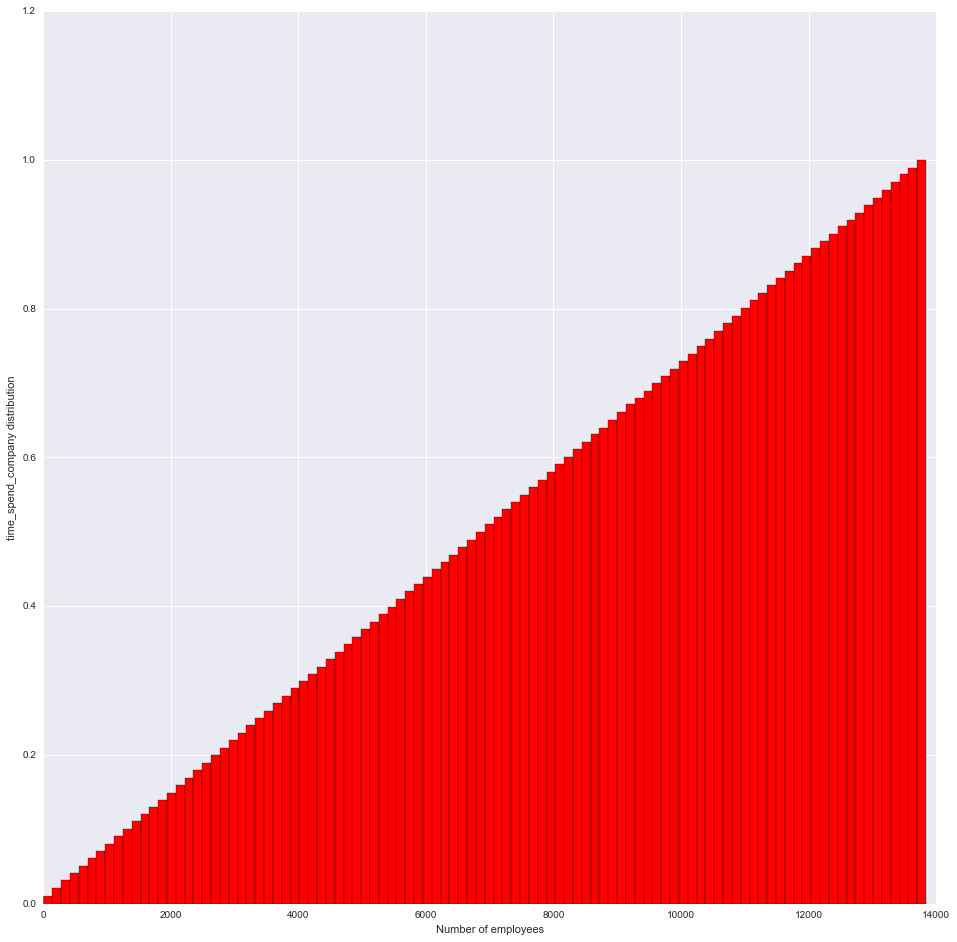

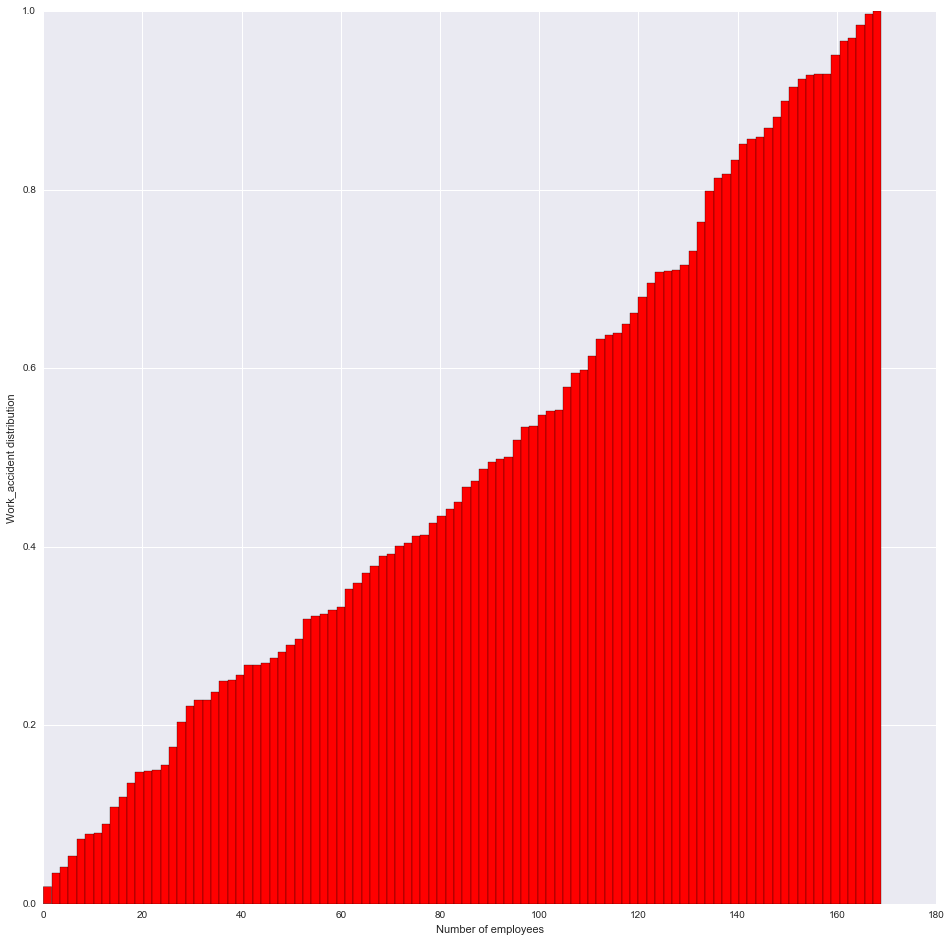

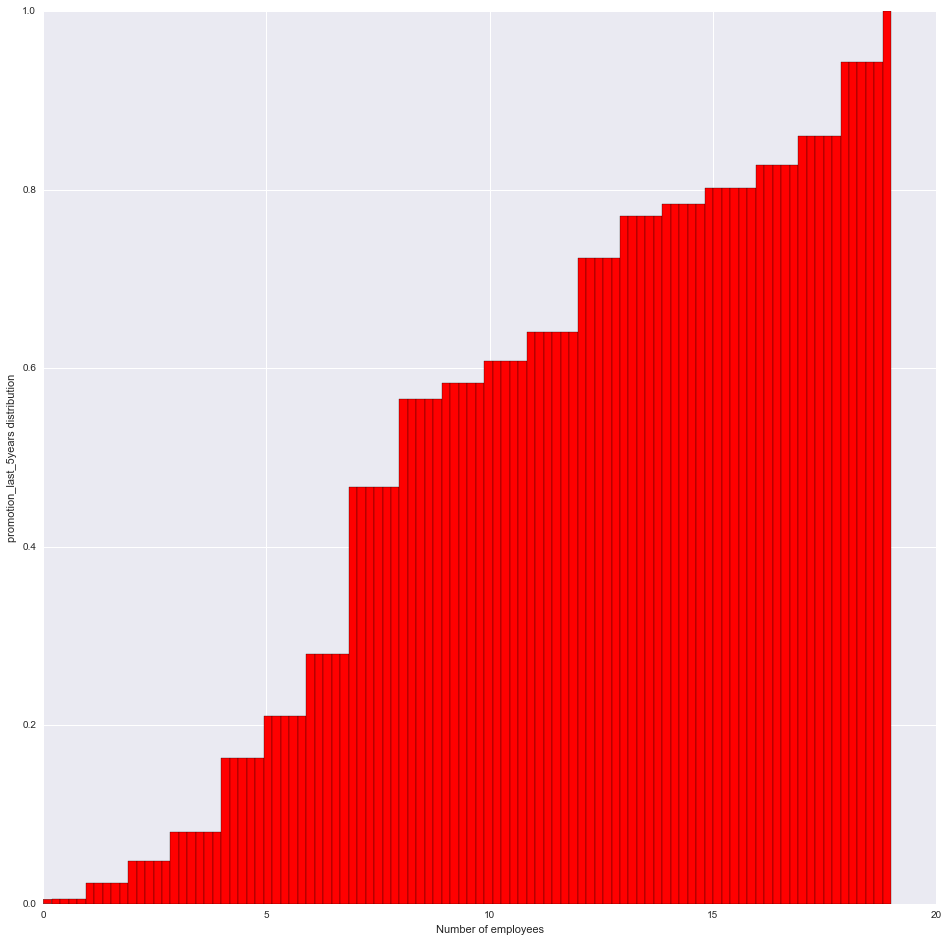

In [69]:
present = visualizedf.loc[visualizedf['left'] == 0]
quit = visualizedf.loc[visualizedf['left'] == 1]

for col in numericColumns:
    plt.figure(figsize=(16, 16))
    ser = pd.Series(present[col].cumsum())
    ser.hist(cumulative=True, normed=1, bins=100)
    plt.ylabel(col+" distribution")
    plt.xlabel("Number of employees")
    plt.show()
    
for col in numericColumns:
    plt.figure(figsize=(16, 16))
    ser = pd.Series(quit[col].cumsum())
    ser.hist(cumulative=True, normed=1, bins=100,color='r')
    plt.ylabel(col+" distribution")
    plt.xlabel("Number of employees")
    plt.show()

## Helper functions for measuring the performance of classifiers

In [91]:
from __future__ import division
def measures(tp,tn,fp,fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn+fp)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    f1_score = (2*tp)/((2*tp)+fp+fn)
    return precision, recall, specificity, accuracy, f1_score

def howgoodisit(result):
    true_positives = result.filter(lambda line: line[1]==0.0 and line[0]==0.0).count()
    true_negatives = result.filter(lambda line: line[1]==1.0 and line[0]==1.0).count()
    false_positives = result.filter(lambda line: line[1]==0.0 and line[0]==1.0).count()
    false_negatives = result.filter(lambda line: line[1]==1.0 and line[0]==0.0).count()
    return measures(true_positives, true_negatives, false_positives, false_negatives)

## Training and test dataset

In [80]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
print trainingData.count()
print testData.count()

10567
4432


## Fitting the dataset with various machine learning algorithms

In [81]:
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=1000)
lrModel = lr.fit(trainingData)

predictions = lrModel.transform(testData)
predictions.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- satisfaction_level: double (nullable = true)
 |-- last_evaluation: double (nullable = true)
 |-- number_project: integer (nullable = true)
 |-- average_montly_hours: integer (nullable = true)
 |-- time_spend_company: integer (nullable = true)
 |-- Work_accident: integer (nullable = true)
 |-- left: integer (nullable = true)
 |-- promotion_last_5years: integer (nullable = true)
 |-- sales: string (nullable = true)
 |-- salary: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [82]:
selected = predictions.select("label", "prediction", "probability")
selected.show()

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.77697641302549...|
|  0.0|       0.0|[0.59339454079627...|
|  0.0|       0.0|[0.65793686279020...|
|  0.0|       0.0|[0.77017435807291...|
|  0.0|       0.0|[0.76106183794182...|
|  0.0|       0.0|[0.69795973045569...|
|  0.0|       0.0|[0.75281798642968...|
|  0.0|       0.0|[0.75226165823401...|
|  0.0|       0.0|[0.69289775060790...|
|  0.0|       0.0|[0.69289775060790...|
|  0.0|       0.0|[0.68586113805961...|
|  0.0|       0.0|[0.74153270537012...|
|  0.0|       0.0|[0.62076415096320...|
|  0.0|       0.0|[0.73576577328656...|
|  0.0|       0.0|[0.67678068206384...|
|  0.0|       0.0|[0.67547231581425...|
|  0.0|       0.0|[0.73109328439357...|
|  0.0|       0.0|[0.72814659424960...|
|  0.0|       0.0|[0.52874904179595...|
|  0.0|       0.0|[0.59081153751529...|
+-----+----------+--------------------+
only showing top 20 rows



In [87]:
test = 

In [92]:
testRdd = test.rdd.map(list)

print howgoodisit(testRdd)

(0.7625348189415042, 0.9736218138707765, 0.0330812854442344, 0.7490974729241877, 0.8552460296797709)


## Evaluating logistic regression

In [13]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print evaluator.getMetricName()
print evaluator.evaluate(predictions)
evaluator.setMetricName("areaUnderPR")
print evaluator.getMetricName()
print evaluator.evaluate(predictions)

areaUnderROC
0.719831991107
areaUnderPR
0.379709825066


In [93]:
lr_preds_and_labels = predictions.select("label", "prediction").rdd.map(list)
[precision, recall, specificity, accuracy, f1_score] = howgoodisit(lr_preds_and_labels)
print precision, recall, specificity, accuracy, f1_score

0.762534818942 0.973621813871 0.0330812854442 0.749097472924 0.85524602968


## Crossvalidation on logistic regression model

In [14]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1000, 5000, 10000])
             .build())

In [15]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=10)
#numFolds=10 indicates 10-fold cross validation.

In [18]:
cvModel = cv.fit(trainingData)

In [19]:
predictions = cvModel.transform(testData)
evaluator.evaluate(predictions)

0.6193592057761733

In [20]:
print 'Model Intercept: ', cvModel.bestModel.intercept
weights = cvModel.bestModel.coefficients
weights = map(lambda w: (float(w),), weights)  # convert numpy type to float, and to tuple
selected = predictions.select("label", "prediction", "probability")
selected.show()

Model Intercept:  -1.16469160387
+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
|  0.0|       0.0|[0.76218415822844...|
+-----+----------+--------------------+
only sh

In [21]:
print evaluator.getMetricName()
print evaluator.evaluate(predictions)
evaluator.setMetricName("areaUnderPR")
print evaluator.getMetricName()
print evaluator.evaluate(predictions)

areaUnderPR
0.619359205776
areaUnderPR
0.619359205776
